In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import shutil
from os import listdir
from os.path import isfile, join
import time
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.lines import Line2D
from scipy.stats import linregress
from datetime import timedelta
import scipy.stats as stats 
from scipy import signal

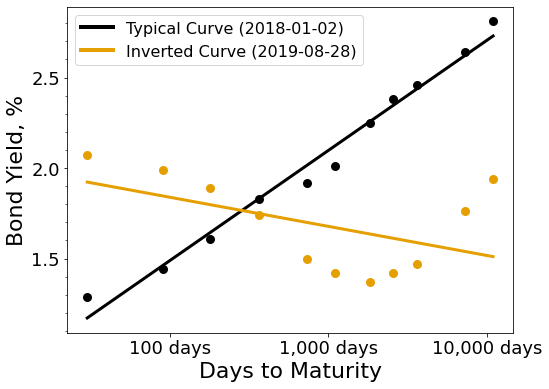

In [2]:
# Load the bonds
bonds = pd.read_csv('Bond_Yields.csv')

# Select interested dates
bonds.Date = pd.to_datetime(bonds['Date'])
all_months = ['2019-08-28','2018-01-02']
all_months = pd.to_datetime(all_months)
b = bonds.loc[bonds.Date == all_months[0]]
c = bonds.loc[bonds.Date == all_months[1]]

# Make a plot
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Pop columns with null data 
x_1 = list(b.columns)
x_1.pop(0)
x_1.pop(1)

# Get the associated values
all_tweets_1 = []
all_tweets_2 = []

for i in range(len(x_1)):
    all_tweets_1.append(b[x_1[i]].mean())
    all_tweets_2.append(c[x_1[i]].mean())
    #all_e.append(mean_confidence_interval(b[x_1[i]]))

# Get a list of x    
x = [30,90,180,365,730,1095,1825,2555,3650,7300,10950]
x = [np.log10(y) for y in x]
x_poly = []
for m in range(len(x)-1):
    if m == 0:
        x_a = 0
    else:
        x_a = x[m-1]
    x_b = x[m]
    for n in [.2,.4,.6,.8,1]:
        x_poly.append(x_a + (x_b - x_a) * n)


        
coef = np.polyfit(x,all_tweets_2,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_2, marker='o', color = "black",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='black',lw=3)
        
coef = np.polyfit(x,all_tweets_1,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_1, marker='o', color = "#E69F00",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='#E69F00',lw=3)


axs.set_ylabel("Bond Yield, %", fontsize = 22)
axs.set_xlabel("Days to Maturity", fontsize = 22)

custom_lines = [Line2D([0], [0], color='black',  lw=4),
                Line2D([0], [0], color='#E69F00', lw=4)]

axs.legend(custom_lines,["Typical Curve ("+str(all_months[1])[:10]+')',"Inverted Curve ("+str(all_months[0])[:10]+')'],fontsize = 16)

#axs.legend(["","Typical (1/2/2018)", "","Inverted (8/13/2019)"],fontsize = 16)
axs.tick_params(labelsize=18)
axs.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
axs.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))

axs.xaxis.set_major_locator(mticker.MultipleLocator(1))
axs.set_xticklabels(('','100 days','1,000 days','10,000 days'))
#axs.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=5))
#axs.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

plt.savefig("plots/Treasury-Bond_Yield-Curve.png",dpi=400)
plt.show()

In [4]:
df_bot_accounts = pd.read_csv('data/bots.csv')
all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']

# Read all of the filenames
all_sents = [f for f in listdir('data/VADER/') if isfile(join('data/VADER/', f))]
all_sents = ["data/VADER/"+f for f in all_sents if f[len(f)-4:]== ".csv"]


var = 'vader'
df = pd.read_csv(all_sents[0])
df['phrase'] = all_sents[0][11:all_sents[0].index('_t')]
df = df[['tweet_id','created_at','phrase',var]]

for i in all_sents[1:]:
    df_1 = pd.read_csv(i)
    df_1['phrase'] = i[11:i.index('_t')]

    df_1 = df_1[['tweet_id','created_at','phrase',var]]
    df = pd.concat([df,df_1])

df = df.loc[df.vader!=0]
df.created_at = pd.to_datetime(df['created_at'])
df = df.dropna(subset=[var])
df = df.loc[~df.tweet_id.isin(list(df_bot_accounts.tweet_id))]


In [5]:
# Helper function to load a specific month
def get_range(t_1,t_2):
    
    df_range = df.copy()
    df_range.created_at = pd.to_datetime(df_range['created_at'])
    # Select only tweets in these dates
    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_range['created_at']) & (df_range['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_range = df_range.loc[mask]

    return df_range

# Helper function for confidence intervals
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2, n-1)
    return h

# Helper function to get the counts of all dates
def get_counts():
    df_counts = pd.DataFrame({'created_at':[],'count':[], 'phrase':[]})

    # For each file
    for f in all_sents:

        # Read in a file
        df_temp = pd.read_csv(f)

        # Remove 0 sentiment:
        df_temp = df_temp.loc[df_temp['Sentiment'] != 0]
        
        # Drop duplicates if they exist
        df_temp = df_temp.drop_duplicates()
        
        # Get the phrase
        phrase = df_temp.phrase.values[0]

        # Change to date-time and group by date
        s = pd.to_datetime(df_temp['created_at'])
        df_temp = s.groupby(s.dt.floor('d')).size().reset_index(name='count')
        df_temp['phrase'] = phrase
        
        df_counts = pd.concat([df_counts,df_temp])
    
    return df_counts

# Helper function to get log x values
def get_x():
    x_1 = [2,3,4,5,7,10,14,21,28,42,60,90,120,150,180,365,730,3*365,4*365,5*365,10*365,20*365,30*365]
    x = [np.log10(n) for n in x_1]  
    return(x)

In [7]:
t_1 = "2017-08-01"
t_2 = "2020-03-11"
t_3 = "2020-04-11"
all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']

x = get_x()
df_cor = df.loc[df.phrase == all_phrases[0]]
df_cor['x'] = x[0]
for i in range(len(all_phrases)-1):
    df_temp =df.loc[df.phrase == all_phrases[i+1]]
    df_temp['x'] = x[i+1]
    df_cor = pd.concat([df_cor,df_temp])

df_temp = df_cor.copy()
mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
df_temp = df_temp.loc[mask]
print(stats.pearsonr(df_temp.vader,df_temp.x))

df_temp = df_cor.copy()
mask = (pd.Timestamp(t_2+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(t_3+' 00:00:00+0000'))
df_temp = df_temp.loc[mask]
print(stats.pearsonr(df_temp.vader,df_temp.x))

/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-0.06010421066583247, 0.0)
(0.021421115301412594, 1.17515772177361e-09)


In [41]:
# Answering comment

t_1 = "2017-08-01"
t_2 = "2020-03-11"
t_3 = "2020-10-31"
all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']

x = get_x()
df_cor = df.loc[df.phrase == all_phrases[0]]
df_cor['x'] = x[0]
for i in range(len(all_phrases)-1):
    df_temp =df.loc[df.phrase == all_phrases[i+1]]
    df_temp['x'] = x[i+1]
    df_cor = pd.concat([df_cor,df_temp])

df_temp = df_cor.copy()
mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
df_temp = df_temp.loc[mask]
print(stats.pearsonr(df_temp.vader,df_temp.x))

df_temp = df_cor.copy()
mask = (pd.Timestamp(t_2+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(t_3+' 00:00:00+0000'))
df_temp = df_temp.loc[mask]
print(stats.pearsonr(df_temp.vader,df_temp.x))

/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


(-0.06010421066583247, 0.0)
(-0.03306091392429305, 2.0460453444325712e-142)


 
-0.04087 x + 0.2515
 
0.001795 x + 0.1086


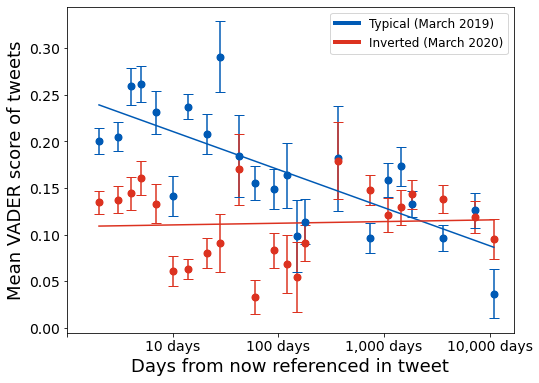

In [42]:
# Plot March 2019 and 2020
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Get all phrases and x locations in log of days
x = get_x()

all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']

# Plot 2019
df_main = get_range("2019-03-01", "2019-04-01") # 2018-03
all_tweets = [df_main.loc[df_main['phrase'] == phrase][var].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase][var]) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='o', ecolor="#005AB5", mec="#005AB5", mfc="#005AB5", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#005AB5")


# Plot 2020
df_main = get_range("2020-03-01", "2020-04-01") #2020 - 03-11
all_tweets = [df_main.loc[df_main['phrase'] == phrase][var].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase][var]) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='o', ecolor="#DC3220", mec="#DC3220", mfc="#DC3220", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#DC3220")

# Labels
#plt.title("Sentiment Curve", fontsize = 24)
plt.ylabel('Mean VADER score of tweets', fontsize = 18)
plt.xlabel("Days from now referenced in tweet", fontsize = 18)

custom_lines = [Line2D([0], [0], color='#005AB5',  lw=4),
                Line2D([0], [0], color='#DC3220', lw=4)]

axs.legend(custom_lines,["Typical (March 2019)","Inverted (March 2020)"],fontsize = 12)

#plt.legend(["(Typical)","March 2018","(Inverted)","March 2020"], loc='best', fontsize = 14)
plt.xticks(np.arange(5), ('','10 days', '100 days','1,000 days','10,000 days'))

axs.tick_params(labelsize=14)
plt.savefig('plots/Sentiment-Yield-Curve-Typical-Inverted-new.png',dpi=400)
plt.show()



 
-0.02896 x + 0.2319
 
-0.01418 x + 0.1497


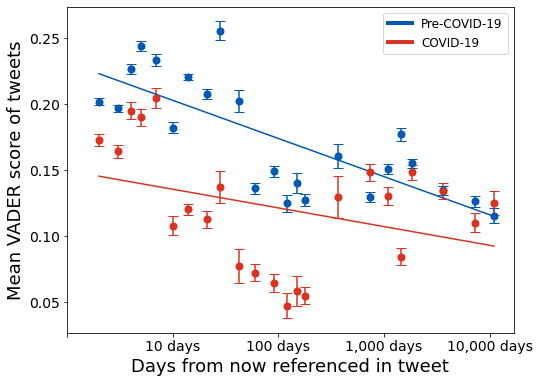

In [43]:
# responding comment

# Plot March 2019 and 2020
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Get all phrases and x locations in log of days
x = get_x()

all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']

# Plot 2019
df_main = get_range("2017-08-01", "2020-03-11") # 2018-03
all_tweets = [df_main.loc[df_main['phrase'] == phrase][var].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase][var]) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='o', ecolor="#005AB5", mec="#005AB5", mfc="#005AB5", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#005AB5")


# Plot 2020
df_main = get_range("2020-03-11", "2020-10-31") #2020 - 03-11
all_tweets = [df_main.loc[df_main['phrase'] == phrase][var].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase][var]) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='o', ecolor="#DC3220", mec="#DC3220", mfc="#DC3220", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#DC3220")

# Labels
#plt.title("Sentiment Curve", fontsize = 24)
plt.ylabel('Mean VADER score of tweets', fontsize = 18)
plt.xlabel("Days from now referenced in tweet", fontsize = 18)

custom_lines = [Line2D([0], [0], color='#005AB5',  lw=4),
                Line2D([0], [0], color='#DC3220', lw=4)]

axs.legend(custom_lines,["Pre-COVID-19","COVID-19"],fontsize = 12)

#plt.legend(["(Typical)","March 2018","(Inverted)","March 2020"], loc='best', fontsize = 14)
plt.xticks(np.arange(5), ('','10 days', '100 days','1,000 days','10,000 days'))

axs.tick_params(labelsize=14)
plt.savefig('SI-plots/Sentiment-Yield-Curve-Typical-Inverted-all.png',dpi=400)
plt.show()

In [10]:
all_months = ["2017-07-01","2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01",
             "2018-01-01","2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01",
             "2018-07-01","2018-08-01","2018-09-01","2018-10-01","2018-11-01","2018-12-01",
             "2019-01-01","2019-02-01","2019-03-01","2019-04-01","2019-05-01","2019-06-01",
             "2019-07-01","2019-08-01","2019-09-01","2019-10-01","2019-11-01","2019-12-01",
             "2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-05-01","2020-06-01",
             "2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01"]

x = get_x()
all_curves = []
all_means = []
for i in range(len(all_months)-1):
    t_1 = all_months[i]
    t_2 = all_months[i+1]

    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df['created_at']) & (df['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_main = df.loc[mask]
    all_means.append(df_main[var].mean())

    all_tweets = [df_main.loc[df_main['phrase'] == phrase][var].mean() for phrase in all_phrases]
    coef = np.polyfit(x,all_tweets,1)
    all_curves.append(coef[0])

    
df_curves = pd.DataFrame({'months':all_months[1:len(all_months)-1],'curve':all_curves[1:],'means':all_means[1:]})


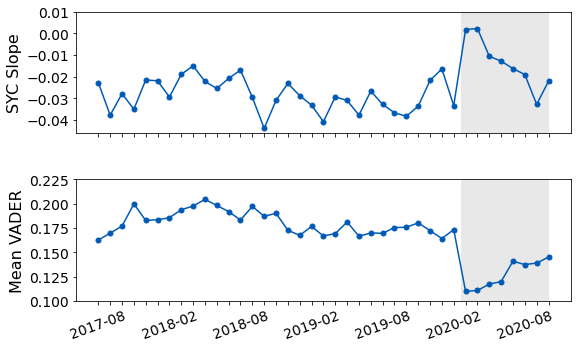

In [27]:
fig, axs = plt.subplots(2, 1,figsize=(8,5))
fig.tight_layout(pad=2.5)

#axs[0].plot(df_curves['months'],df_curves['curve'])
axs[0].plot(df_curves['months'],df_curves['curve'],marker='o',markersize=5,color='#005AB5')
#axs[0].set_title("Sentiment Yield Curve over time",fontsize=22)
axs[0].set_ylabel('SYC Slope',fontsize=16)
axs[0].axvspan(30.6, 38, facecolor="#D3D3D3", alpha=0.5)
axs[0].set_xticks(np.arange(39))
axs[0].set_yticks([-.04,-.03,-.02,-.01,0,.01])
axs[0].tick_params(labelsize=14)
axs[0].set_xticklabels(['',"","",'',"","",'',"","",
                          '',"","",'',"","",'',"","",
                          '',"","",'',"","",'',"","",
                          '',"","",'',"","",'',"","",""])

axs[1].plot(df_curves['months'],df_curves['means'],marker='o',markersize=5,color='#005AB5')
#axs[1].set_title("Sentiment over time")
axs[1].set_ylabel('Mean VADER',fontsize=16)
axs[1].set_xticks(np.arange(39))
axs[1].set_yticks([.1,.125,.15,.175,.2,.225])
axs[1].tick_params(labelsize=14)
axs[1].axvspan(30.6, 38, facecolor="#D3D3D3", alpha=0.5)
axs[1].set_xticklabels(['2017-08',"","",'',"","",'2018-02',"","",
                          '',"","",'2018-08',"","",'',"","",
                          '2019-02',"","",'',"","",'2019-08',"","",
                          '',"","",'2020-02',"","",'',"","",'2020-08',""],rotation = 20)
plt.savefig("plots/regular-sentiment-over-time.png",dpi=400)
plt.show()

39 39 39


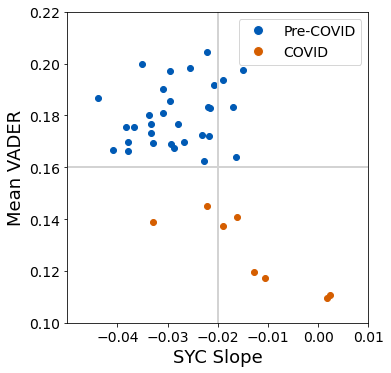

In [28]:
fig, axs = plt.subplots(1, 1,figsize=(6,6))
plt.tight_layout(pad = 5)
#axs.axhspan(.16, .22, facecolor='yellow', alpha=0.3)
#axs.axhspan(.1, .16, facecolor='red', alpha=0.3)
#axs.axvspan(-.05, -.02, facecolor='blue', alpha=0.2)
axs.plot([-.02, -.02], [.1, .22], '-', color = '#d3d3d3', lw=2)
axs.plot([-.05, .02], [.16, .16], '-', color = '#d3d3d3', lw=2)

linear_rels = list(df_curves['curve'])
month_means_2 = list(df_curves['means'])
cols = ['#005AB5' for i in range(len(month_means_2) - 8)]
for i in range(8):
    cols.append('#D55E00')
    
print(len(linear_rels),len(month_means_2),len(cols))
for i in range(len(month_means_2)):
    plt.scatter(linear_rels[i],month_means_2[i],color=cols[i])
    
axs.set_ylim([.1,.22])
axs.set_xlim([-.05,.005])
#plt.plot(linear_rels,month_means_2, color = 'black')

#axs.set_title("Optimism toward future", fontsize = 22)
axs.set_ylabel('Mean VADER',fontsize=18)
axs.set_xlabel('SYC Slope',fontsize=18)
axs.tick_params(labelsize=14)
custom_lines = [Line2D([0], [0], marker='o',color='w',markerfacecolor='#005AB5', markersize=10),
                Line2D([0], [0], marker='o',color='w',markerfacecolor='#D55E00', markersize=10)]
axs.legend(custom_lines,['Pre-COVID','COVID'],loc='best',fontsize=14)
axs.set_xticks([-.04,-.03,-.02,-.01,.0,.01])
plt.savefig('plots/regular-2x2nice.png',dpi = 400)
plt.show()

In [27]:
for col in ['means','curve']:
    col_zscore = col + '_zscore'
    df_curves[col_zscore] = (df_curves[col] - df_curves[col].mean())/df_curves[col].std(ddof=0)

print(df_curves['means'].min(), df_curves['means_zscore'].min())
print(df_curves['curve'].max(), df_curves['curve_zscore'].max())

df_curves

0.10972947571606839 -2.435146428945527
0.0022739139716992504 2.7019316473000297


,months,curve,means,means_zscore,curve_zscore
0,2017-08-01,-0.022824,0.162461,-0.278558,0.259596
1,2017-09-01,-0.037800,0.169673,0.016368,-1.197712
2,2017-10-01,-0.027907,0.176814,0.308420,-0.234988
3,2017-11-01,-0.035067,0.199691,1.244039,-0.931769
4,2017-12-01,-0.021530,0.182704,0.549320,0.385572
5,2018-01-01,-0.021932,0.183401,0.577827,0.346388
6,2018-02-01,-0.029429,0.185451,0.661669,-0.383071
7,2018-03-01,-0.018963,0.193765,1.001651,0.635322
8,2018-04-01,-0.015010,0.197433,1.151681,1.020028
9,2018-05-01,-0.022214,0.204373,1.435520,0.318956


In [28]:
# addressing comment

df_temp = df_curves.copy()
df_temp = df_temp.loc[df_temp.months < "2020-03-01"]

df_curves['means_zscore'] = (df_curves['means'] - df_temp['means'].mean())/ df_temp['means'].std(ddof=0)
df_curves['curve_zscore'] = (df_curves['curve'] - df_temp['curve'].mean())/ df_temp['curve'].std(ddof=0)


print(df_curves['means'].min(), df_curves['means_zscore'].min())
print(df_curves['curve'].max(), df_curves['curve_zscore'].max())

df_curves

0.10972947571606839 -6.050911878662432
0.0022739139716992504 4.1120454960246375


,months,curve,means,means_zscore,curve_zscore
0,2017-08-01,-0.022824,0.162461,-1.515478,0.762224
1,2017-09-01,-0.037800,0.169673,-0.895230,-1.236568
2,2017-10-01,-0.027907,0.176814,-0.281028,0.083870
3,2017-11-01,-0.035067,0.199691,1.686635,-0.871810
4,2017-12-01,-0.021530,0.182704,0.225600,0.935009
5,2018-01-01,-0.021932,0.183401,0.285552,0.881266
6,2018-02-01,-0.029429,0.185451,0.461876,-0.119235
7,2018-03-01,-0.018963,0.193765,1.176878,1.277557
8,2018-04-01,-0.015010,0.197433,1.492402,1.805206
9,2018-05-01,-0.022214,0.204373,2.089332,0.843640


In [31]:
df_bot_accounts = pd.read_csv('data/bots.csv')
all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']

# Read all of the filenames
all_sents = [f for f in listdir('data/VADER/') if isfile(join('data/VADER/', f))]
all_sents = ["data/VADER/"+f for f in all_sents if f[len(f)-4:]== ".csv"]


var = 'vader'
df = pd.read_csv(all_sents[0])
df['phrase'] = all_sents[0][11:all_sents[0].index('_')]
df = df[['tweet_id','created_at','user_id','phrase',var]]

for i in all_sents[1:]:
    df_1 = pd.read_csv(i)
    df_1['phrase'] = i[11:i.index('_')]

    df_1 = df_1[['tweet_id','created_at','user_id','phrase',var]]
    df = pd.concat([df,df_1])

print(df.vader.count())
df = df.loc[df.vader!=0]
df.created_at = pd.to_datetime(df['created_at'])
df = df.dropna(subset=[var])
print(df.vader.count())
df = df.loc[~df.user_id.isin(list(df_bot_accounts.user_id))]
print(df.vader.count())


3560551
2323346
2225598


In [32]:
all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']
for p in all_phrases:
    df_temp = df.loc[df.phrase == p]
    print(p, df_temp.vader.count())

2-days 225192
3-days 190014
4-days 105426
5-days 100079
7-days 71448
10-days 95711
2-weeks 235349
3-weeks 99283
4-weeks 27604
6-weeks 22329
2-months 87030
3-months 85981
4-months 40477
5-months 29376
6-months 90145
12-months 17559
2-years 113915
3-years 101085
4-years 81870
5-years 129564
10-years 139412
20-years 88286
30-years 48463


# All Months (For dip)

In [33]:
df_temp = df.loc[df.created_at < '2020-03-01']
df_temp = df_temp.loc[df_temp.created_at >= '2017-08-01']

print("Near:",df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') ].vader.mean())
print("Med:",df_temp.loc[(df_temp.phrase == '4-weeks') | (df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')].vader.mean())
print("far:",df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')].vader.mean())

df_temp = df.loc[df.created_at > '2020-03-01']
print("Near:",df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') ].vader.mean())
print("Med:",df_temp.loc[(df_temp.phrase == '4-weeks') | (df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months') | (df_temp.phrase == '12-months') ].vader.mean())
print("far:",df_temp.loc[(df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')].vader.mean())


Near: 0.20959726836685413
Med: 0.1496017740477852
far: 0.14239235013556656
Near: 0.1653795457151237
Med: 0.07074559754015604
far: 0.12757013085313704


In [39]:
all_months = ["2017-07-01","2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01",
             "2018-01-01","2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01",
             "2018-07-01","2018-08-01","2018-09-01","2018-10-01","2018-11-01","2018-12-01",
             "2019-01-01","2019-02-01","2019-03-01","2019-04-01","2019-05-01","2019-06-01",
             "2019-07-01","2019-08-01","2019-09-01","2019-10-01","2019-11-01","2019-12-01",
             "2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-05-01","2020-06-01",
             "2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01"]

m_vader = []
counts = []
phrases = []
month = []
# Load the data file for every phrase & get only tweets with some vader
for phrase in all_phrases:
    df_temp = pd.read_csv('data/VADER/'+phrase+"_tweets.csv")
    df_temp.created_at = pd.to_datetime(df_temp.created_at)
    df_temp = df_temp.loc[~df_temp.user_id.isin(list(df_bot_accounts.user_id))]
    df_temp = df_temp.loc[df_temp.vader != 0]
    for m in range(len(all_months)-1):
        
        # Look at each month individually 
        mask = (pd.Timestamp(all_months[m]+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(all_months[m+1]+' 00:00:00+0000'))
        df_main = df_temp.loc[mask]
        
        
        # Store mean vader, fear, concreteness, count, and phrase
        m_vader.append(df_main.vader.mean())
        counts.append(df_main.vader.count())
        phrases.append(phrase)
        month.append(all_months[m])

df_months = pd.DataFrame({'month_VADER':m_vader,'count':counts,'phrase':phrases,'month':month})


Skew -0.022459588601472947
Kurtosis 0.20126248744772868


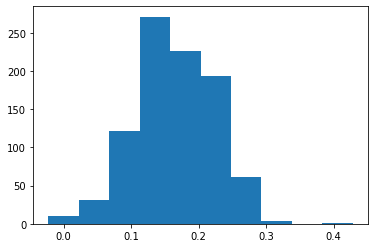

Skew -0.03942709107417684
Kurtosis -0.29025047404803717 Count 713
Near: 0.219338624512753
Med: 0.14758088715728393
far: 0.1453846258074638
all F_onewayResult(statistic=262.5224699487698, pvalue=3.480108455662576e-85)
n-m F_onewayResult(statistic=333.32761445236554, pvalue=1.3079824374844464e-55)
n-f F_onewayResult(statistic=463.52313776531776, pvalue=5.2257957994527306e-73)
m-f F_onewayResult(statistic=0.29718048226439603, pvalue=0.5859367557150919)
Skew -0.19753425897676605
Kurtosis -0.17330744063760584 Count 184
Near: 0.16223684102184266
Med: 0.06922519137559098
far: 0.12806795105306965
all F_onewayResult(statistic=79.02711655672526, pvalue=4.165928741372009e-25)
n-m F_onewayResult(statistic=122.56410147983681, pvalue=1.3573206115576046e-19)
n-f F_onewayResult(statistic=26.4451868081814, pvalue=1.0082223453994588e-06)
m-f F_onewayResult(statistic=79.51940563006113, pvalue=1.1729549752341361e-14)


In [40]:
from scipy.stats import kurtosis, skew,jarque_bera, f_oneway

print('Skew',skew(df_months['month_VADER']))
print('Kurtosis',kurtosis(df_months['month_VADER']))
plt.hist(df_months['month_VADER'])
plt.show()

df_temp = df_months.loc[df_months.month < '2020-03-01']
df_temp = df_temp.loc[df_temp.month >= '2017-08-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean())
print("Med:",med.month_VADER.mean())
print("far:",far.month_VADER.mean())

print('all',f_oneway(near.month_VADER,med.month_VADER,far.month_VADER))
print('n-m',f_oneway(near.month_VADER,med.month_VADER))
print('n-f',f_oneway(near.month_VADER,far.month_VADER))
print('m-f',f_oneway(med.month_VADER,far.month_VADER))

df_temp = df_months.loc[df_months.month >= '2020-03-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())

near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean())
print("Med:",med.month_VADER.mean())
print("far:",far.month_VADER.mean())

print('all',f_oneway(near.month_VADER,med.month_VADER,far.month_VADER))
print('n-m',f_oneway(near.month_VADER,med.month_VADER))
print('n-f',f_oneway(near.month_VADER,far.month_VADER))
print('m-f',f_oneway(med.month_VADER,far.month_VADER))


In [41]:
# SI table descriptives
df_temp = df_months.loc[df_months.month < '2020-03-01']
df_temp = df_temp.loc[df_temp.month >= '2017-08-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean(),near.month_VADER.std())
print('Skew',skew(near['month_VADER']))
print('Kurtosis',kurtosis(near['month_VADER']), "Count",near.month_VADER.count())
print("jb",jarque_bera(near['month_VADER']))

print("Med:",med.month_VADER.mean(),med.month_VADER.std())
print('Skew',skew(med['month_VADER']))
print('Kurtosis',kurtosis(med['month_VADER']), "Count",med.month_VADER.count())
print("jb",jarque_bera(med['month_VADER']))

print("far:",far.month_VADER.mean(),far.month_VADER.std())
print('Skew',skew(far['month_VADER']))
print('Kurtosis',kurtosis(far['month_VADER']), "Count",far.month_VADER.count())
print("jb",jarque_bera(far['month_VADER']))

print("\n\nPandemic")
df_temp = df_months.loc[df_months.month >= '2020-03-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean(),near.month_VADER.std())
print('Skew',skew(near['month_VADER']))
print('Kurtosis',kurtosis(near['month_VADER']), "Count",near.month_VADER.count())
print("jb",jarque_bera(near['month_VADER']))

print("Med:",med.month_VADER.mean(),med.month_VADER.std())
print('Skew',skew(med['month_VADER']))
print('Kurtosis',kurtosis(med['month_VADER']), "Count",med.month_VADER.count())
print("jb",jarque_bera(med['month_VADER']))

print("far:",far.month_VADER.mean(),far.month_VADER.std())
print('Skew',skew(far['month_VADER']))
print('Kurtosis',kurtosis(far['month_VADER']), "Count",far.month_VADER.count())
print("jb",jarque_bera(far['month_VADER']))


Skew -0.03942709107417684
Kurtosis -0.29025047404803717 Count 713
Near: 0.219338624512753 0.03728663282238312
Skew -0.3315851318719981
Kurtosis 0.6977596023251595 Count 248
jb Jarque_beraResult(statistic=9.575520367296216, pvalue=0.00833109662634135)
Med: 0.14758088715728393 0.04447223480073863
Skew 0.5265142126031828
Kurtosis 0.5049679106006528 Count 186
jb Jarque_beraResult(statistic=10.569926276474636, pvalue=0.005067218971341325)
far: 0.1453846258074638 0.03919061343354578
Skew -0.4698057597344444
Kurtosis 1.688024517046074 Count 248
jb Jarque_beraResult(statistic=38.56706463589504, pvalue=4.219571247965348e-09)


Pandemic
Skew -0.19753425897676605
Kurtosis -0.17330744063760584 Count 184
Near: 0.16223684102184266 0.045390468238518646
Skew -0.42027859313075483
Kurtosis -0.06515508543140625 Count 64
jb Jarque_beraResult(statistic=1.8954175160891735, pvalue=0.38762815664360584)
Med: 0.06922519137559098 0.04206529188487145
Skew 0.19903456809440287
Kurtosis 0.13475853734079868 Count 48
